# W207.6 Final Project - Predicting Cancer Type from Tumor Mutations
### Tony Di Sera, Vijay Singh, Rajiv Nair, Jeremey Fraenkel


In [1]:
import pandas as pd
import urllib.request
import numpy as np
import glob
import os
import warnings
from textwrap import wrap
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
#import xgboost as xgb
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.layers import Dense as Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#cd /content/drive/My Drive/berkeley/W207 machine learning/Final Project/w207_6_sum19_g5_final_project

# Data Collection
For our analysis of cancer prediction using gene mutation and clinical data from patients, we will gather data from multiple sources. First we obtain the gene mutation data from the  𝑐𝑎𝑛𝑐𝑒𝑟.𝑔𝑜𝑣  website. Next we get the patient clinical data also from the  𝑐𝑎𝑛𝑐𝑒𝑟.𝑔𝑜𝑣  website. In our notebook, we store this data locally so that it does not have to downloaded if the notebook kernel is restarted and run multiple times.

In [4]:
# to make this notebook's output stable across runs
np.random.seed(42)

In [5]:
# create the directory where the downloaded directory is stored
data_dir = "./data"
if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

In [6]:
# This downloads a 753 MB somatic mutations gzip file.  
# This will take about 1-5 mins depending on your
# connection speed.
mutations_filename = "./data/somatic_mutations.maf.gz"
if os.path.isfile(mutations_filename):
    print("Skipping download, as file %s is present" %(mutations_filename))
else:
    print('Downloading mutation data. 753 MB (may take a few minutes)...')
    url = 'http://api.gdc.cancer.gov/data/1c8cfe5f-e52d-41ba-94da-f15ea1337efc'  
    urllib.request.urlretrieve(url, mutations_filename)  
print("done.")

Skipping download, as file ./data/somatic_mutations.maf.gz is present
done.


In [7]:
# This downloads an 18 MB patient clinical data file
patient_filename = "./data/patient_clinical_data.txt"
if os.path.isfile(patient_filename):
    print("Skipping download, as file %s is present" %(patient_filename))
else:
    print('Downloading clinical data ...')
    url = 'http://api.gdc.cancer.gov/data/0fc78496-818b-4896-bd83-52db1f533c5c'  
    urllib.request.urlretrieve(url, patient_filename)  
print("done.")

Skipping download, as file ./data/patient_clinical_data.txt is present
done.


## Loading Gene Mutation Data ##

Here we read the gene mutation data. This data file contains many columns, but after careful curation, we have decided to consider the following colums:

1. **tumor_sample_barcode**: this contains the barcode with the first 12 characters identifying the patient
2. **gene**: this is the actual gene that has been mutated (for e.g. TACC2, JAKMIP3, PANX3)
3. **gene_type**: this indicates if the gene is protein coding or not.
4. **chromosome**  **start** **end** **Strand**: the chromosome, start position and end position tells us the location of the gene where the mutation is seen.  Strand indicates if it is on the forward or reverse strand of the DNA.
5. **variant_type**: this indicates if it is a single substitution mutation (SNP), a small deletion (DEL), or small insertion (INS), two nucleotide substitution (DNP), three nucleotide substitution (TNP), or more that three nucleotide substitution (ONP)
6. **variant_classification**: this indicates what kind of molecular effect that this mutation will have on the protein.  The most common classes indicate if the substitution causes a change to the amino acid (missense vs silent).  Nonsense mutations cause premature termination of the protein; frameshift mutations cause a misreading of the amino acid sequence.
7. **variant_impact**: this indicates how damaging the mutation -- HIGH, MODERATE, MODIFIER, or LOW.


In [8]:
# Load the mutations dataframe
print('Loading mutations dataframe ...')

mutations = pd.read_csv(mutations_filename, compression='gzip',
                        sep='\t',
                        usecols=['Tumor_Sample_Barcode','Hugo_Symbol', 'BIOTYPE',
                                'Chromosome', 'Start_Position',  'End_Position', 'Strand',
                                'Variant_Type',  'Variant_Classification', 'IMPACT' ])

print("done.")

# Set mutations index
mutations['row'] = np.arange(len(mutations))
mutations.set_index('row', inplace=True)

# Rename the columns to more consistent names
renamed_columns = { 'Tumor_Sample_Barcode': 'tumor_sample_barcode', 
                    'Hugo_Symbol': 'gene', 
                    'BIOTYPE': 'gene_type', 
                    'Chromosome': 'chromosome', 
                    'Start_Position': 'start', 
                    'End_Position': 'end', 
                    'Strand': 'strand', 
                    'Variant_Type': 'variant_type', 
                    'Variant_Classification': 'variant_classification', 
                    'IMPACT': 'variant_impact'}
mutations.rename(renamed_columns, inplace=True, axis=1)


print("\nMutations count:       ", mutations.tumor_sample_barcode.count())
print("Number of unique samples:", mutations.tumor_sample_barcode.nunique())
mutations.head(5)

Loading mutations dataframe ...


/Users/tonyd/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


done.

Mutations count:        3600963
Number of unique samples: 10295


,gene,chromosome,start,end,strand,variant_classification,variant_type,tumor_sample_barcode,gene_type,variant_impact
row,,,,,,,,,,
0,TACC2,10,123810032,123810032,+,Missense_Mutation,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,MODERATE
1,JAKMIP3,10,133967449,133967449,+,Silent,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,LOW
2,PANX3,11,124489539,124489539,+,Missense_Mutation,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,MODERATE
3,SPI1,11,47380512,47380512,+,Missense_Mutation,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,MODERATE
4,NAALAD2,11,89868837,89868837,+,Missense_Mutation,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,MODERATE


The actual cancer type for each of the gene mutations above is kept in a different file. The entries are located at corresponding rows, so we use that to merge the cancer type from the labels.txt file.

In [9]:
# Read the cancer types.  These are the matching labels for the mutations file
print("Loading labels dataframe ...")
labels = pd.read_csv("./data/labels.txt", sep='\t')
labels.columns = ["cancer_type"]
labels['row'] = np.arange(len(labels))
labels.set_index('row', inplace=True)
print('Labels count:', labels.cancer_type.count())

Loading labels dataframe ...
Labels count: 3600963


In [10]:
# Merge the labels with the mutations
mutations = mutations.merge(labels, left_on='row', right_on='row')
display(mutations.head(5))

,gene,chromosome,start,end,strand,variant_classification,variant_type,tumor_sample_barcode,gene_type,variant_impact,cancer_type
row,,,,,,,,,,,
0,TACC2,10,123810032,123810032,+,Missense_Mutation,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,MODERATE,GBM
1,JAKMIP3,10,133967449,133967449,+,Silent,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,LOW,GBM
2,PANX3,11,124489539,124489539,+,Missense_Mutation,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,MODERATE,GBM
3,SPI1,11,47380512,47380512,+,Missense_Mutation,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,MODERATE,GBM
4,NAALAD2,11,89868837,89868837,+,Missense_Mutation,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,MODERATE,GBM


## Loading Patient Data##

Here we load the clinical data. This is data for patients for whom we collected the gene mutation data above. The patients are identified by $patient\_barcode$. We will use this field to populate the gene mutation data from the dataframe above in the table we are about to read. The clinical data has patient information such as gender and age at diagnosis.

Loading clinical dataframe ...
Clinical count 10956


/Users/tonyd/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,patient_barcode,cancer_type,gender,age_at_initial_pathologic_diagnosis
0,TCGA-OR-A5J1,ACC,MALE,58
1,TCGA-OR-A5J2,ACC,FEMALE,44
2,TCGA-OR-A5J3,ACC,FEMALE,23
3,TCGA-OR-A5J4,ACC,FEMALE,23
4,TCGA-OR-A5J5,ACC,MALE,30



Number of cancer types 32
Number of patients 10956


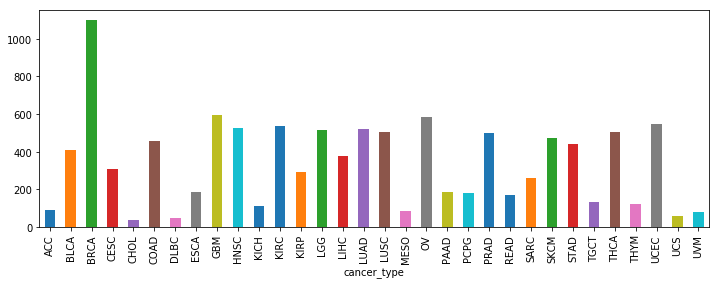

In [11]:
# Load the clinical data
print('Loading clinical dataframe ...')
clinical = pd.read_csv(patient_filename, sep='\t',
                        usecols=['bcr_patient_barcode', 'acronym', 'gender', 
                                 'age_at_initial_pathologic_diagnosis'])

# Rename the columns to more consistent names
renamed_columns = { 'bcr_patient_barcode': 'patient_barcode', 
                    'acronym': 'cancer_type' }
clinical.rename(renamed_columns, inplace=True, axis=1)

print('Clinical count', clinical.patient_barcode.count())
display(clinical.head(5))

# Get cancer types
cancer_types = clinical['cancer_type'].unique()
print("\nNumber of cancer types", len(cancer_types))

# Get number of cases per cancer type
group_by_patient = clinical.groupby(['cancer_type'])['patient_barcode'].nunique()
print("Number of patients", group_by_patient.sum())
group_by_patient.plot.bar(figsize=(12,4))

## Creating Merged Data ##

Now that we have both gene and cancer data in one dataframe, and the patient clinical data in another dataframe, we will use the **patient_barcode** to merge these into a single table. With this, we can drop the tumor_sample_barcode column, since it has served its purpose. Looking at the data, it seems like some patient data is missing from the gene data. Simultaneously, some data in the gene dataframe does not have corresponding clinical data. Hence our merged dataframe size will be lower than the original mutations dataframe size.

In [12]:
# Get the patient barcode.  This is what we will use to join the mutations to the clinical data
def parsePatientBarcode(tumor_sample_barcode):
        return tumor_sample_barcode[0:12]


mutations['patient_barcode'] = mutations['tumor_sample_barcode'].apply(parsePatientBarcode)
mutations = mutations.drop(['tumor_sample_barcode'], axis=1)
mutations = mutations.drop(['cancer_type'], axis=1)
print("Number of unique patients:", mutations['patient_barcode'].nunique())

Number of unique patients: 10224


In [13]:
clinical['patient_barcode'].isnull().values.any()

False

In [14]:
missing_count = 0
gene_barcode_set = set(mutations.patient_barcode.unique())
for bc in gene_barcode_set:
    if bc not in set(clinical.patient_barcode.unique()):
        missing_count += 1
print("%d patients with gene data missing in clinical data" %missing_count)

216 patients with gene data missing in clinical data


In [15]:
merged = mutations.merge(clinical, left_on='patient_barcode', right_on='patient_barcode')
print('Merged mutations count:   ', merged.patient_barcode.count())
print('Number of unique patients:', merged.patient_barcode.nunique())
print('Number of cancer types:   ', merged.cancer_type.nunique())

Merged mutations count:    3570876
Number of unique patients: 10008
Number of cancer types:    32


In [16]:
# Eliminate non-coding genes
def eliminate_non_coding_genes(data):
    data                       = data[data.gene_type == 'protein_coding']
    return data

before_count               = merged.gene.nunique()
merged = eliminate_non_coding_genes(merged)
after_count                = merged.gene.nunique()
print("Filtered out ", str(before_count -after_count), "genes")


Filtered out  2113 genes


In [17]:
#
# Split the patients into training and test
#
def splitPatientData():
    patient_data = merged.patient_barcode.unique()

    le     = preprocessing.LabelEncoder()
    patient_labels_string = merged.groupby('patient_barcode')['cancer_type'].nunique()
    patient_labels = le.fit_transform(patient_labels_string)
    
    print("Number of unique patients:           ", patient_data.shape[0])
    print("Number of labels for unique patients:", len(patient_labels))
    
    train_data, test_data, train_labels, test_labels = train_test_split(
                                                               patient_data, patient_labels,
                                                               stratify=patient_labels, 
                                                               test_size=0.20)



    print("\ntraining patients:  ", train_data.shape[0])
    print("test patients:      ", test_data.shape[0])
    return {'train_patients': train_data, 'test_patients': test_data}


#
#  Split Mutations data (based on patient split) and 
#  write out data files
#
def splitAndSaveMutationData():
    split = splitPatientData()
    train_patients = split['train_patients']
    test_patients  = split['test_patients']

    train_mutations = merged[merged.patient_barcode.isin(train_patients)]
    test_mutations  = merged[merged.patient_barcode.isin(test_patients)]
    print("\ntraining data:      ", train_mutations.shape[0])
    print("test data:          ", test_mutations.shape[0])
    print("\nall data:           ", merged.shape[0])
    print("train + test:       ", train_mutations.shape[0] + test_mutations.shape[0])
    
    # Write out mutations training data as csv file
    print("\nWriting training set ...")
    train_mutations.to_csv("./data/somatic_mutations_train.csv")
    print("done.")

    # Write out mutations test data as csv file
    print("\nWriting test set ...")
    test_mutations.to_csv("./data/somatic_mutations_test.csv")
    print("done.")

splitAndSaveMutationData()

Number of unique patients:            10008
Number of labels for unique patients: 10008

training patients:   8006
test patients:       2002

training data:       2856316
test data:           632127

all data:            3488443
train + test:        3488443

Writing training set ...
done.

Writing test set ...
done.


In [18]:
# Remove old features_ files
filenames = glob.glob('./data/features_*.csv')
 
# Iterate over the list of filepaths & remove each file.
for filePath in filenames:
    try:
        os.remove(filePath)
    except OSError:
        print("Error while deleting file")

# EDA and Feature Selection

Here, we open the data we put together in the previous notebook. For the first analysis, we look at $cancer\_type$, $patient\_barcode$, $gene$ and $gene_type$.

In [19]:
print('Loading data ...')
mutations = {}
mutations['train'] = pd.read_csv("./data/somatic_mutations_train.csv", 
                             usecols=['cancer_type', 'patient_barcode', 'gene', 'gene_type'])
mutations['test']  = pd.read_csv("./data/somatic_mutations_test.csv", 
                             usecols=['cancer_type', 'patient_barcode', 'gene', 'gene_type'])
print("done.")
print("Mutations training data count:", mutations['train']['patient_barcode'].count())
print("Mutations test data count:    ", mutations['test']['patient_barcode'].count())

Loading data ...
done.
Mutations training data count: 2856316
Mutations test data count:     632127


Genes by patient frequency
  mean: 114
  min:  1
  max:  3093


Text(0.5, 0, 'Number of Patients')

Text(0, 0.5, 'Gene Frequency')

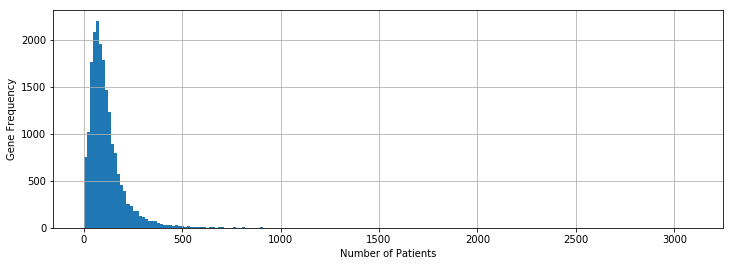


Genes by cancer type frequency
  mean: 18
  min:  1
  max:  32


Text(0.5, 0, 'Number of Cancer Types')

Text(0, 0.5, 'Gene Frequency')

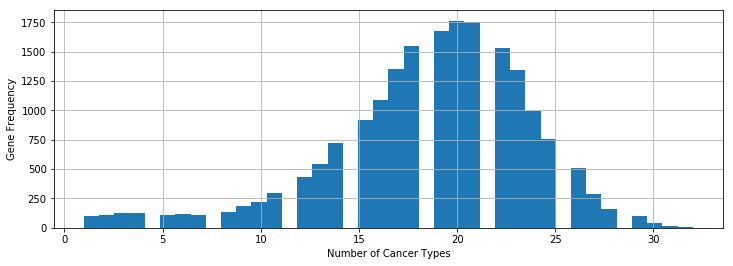

In [20]:
# Show the distribution of genes across patient tumors
gene_count         = mutations['train'].groupby(['gene'])['patient_barcode'].nunique().reset_index(name='count')
gene_count.columns = ['gene', 'patient_count']
gene_count         = gene_count.sort_values(['patient_count', 'gene'], ascending=[0,1])
print('Genes by patient frequency')
print("  mean:", int(gene_count['patient_count'].mean()))
print("  min: ", int(gene_count['patient_count'].min()))
print("  max: ", int(gene_count['patient_count'].max()))

ax = gene_count['patient_count'].hist(bins=200, figsize=(12,4))
ax.set_xlabel("Number of Patients")
ax.set_ylabel("Gene Frequency")
plt.show()

gene_cc_count         = mutations['train'].groupby(['gene'])['cancer_type'].nunique().reset_index(name='count')
gene_cc_count.columns = ['gene', 'cancer_type_count']
gene_cc_count         = gene_cc_count.sort_values(['cancer_type_count', 'gene'], ascending=[0,1])
print('\nGenes by cancer type frequency')
print("  mean:", int(gene_cc_count['cancer_type_count'].mean()))
print("  min: ", int(gene_cc_count['cancer_type_count'].min()))
print("  max: ", int(gene_cc_count['cancer_type_count'].max()))


ax = gene_cc_count['cancer_type_count'].hist(bins=40, figsize=(12,4))
ax.set_xlabel("Number of Cancer Types")
ax.set_ylabel("Gene Frequency")
plt.show()



From the histogram above, it is clear that even through we have a large number of genes, only a small number of them are turned on in the patient tumor data that we have. This is the classic problem of a large feature space with a much smaller number of samples. Hence we will need to perform a dimensionality reduction technique such as PCA here.


Number of cancer types: 32

Number of patients: 8006


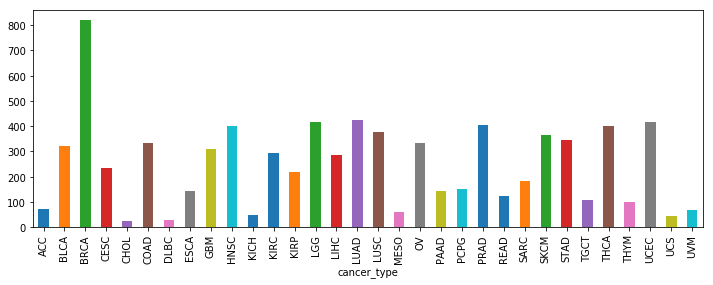

In [21]:
# Print out the number of cancer types that are present in the 
# mutations dataset
cancer_types = mutations['train'].cancer_type.unique()
print("\nNumber of cancer types:", len(cancer_types))

# Get number of cases per cancer type
group_patients_by_cancer = mutations['train'].groupby(['cancer_type'])['patient_barcode'].nunique()
print("\nNumber of patients:", group_patients_by_cancer.sum())
group_patients_by_cancer.plot.bar(figsize=(12,4))

The above chart shows that there are some cancers, such as BRCA and LUAD that have a large representation in our dataset, but other such as DBLC and UCS that are present in much smaller numbers. This will present a challenge for our classifier. Specifically, we want our classifier to be able to classify each of the 32 types of cancers with high precision, but the model should also be able to identify the cancers that don't have a proportionate representation in our data set. It could be that these are cancers are rare, or perhaps they are simply rare in our dataset. **Note:** add more details about the cancers that are abundant as well as rare in this dataset.

Mean number of genes represented for each cancer type: 11173
Min number of genes represented for each cancer type:  1452
Max number of genes represented for each cancer type:  19069


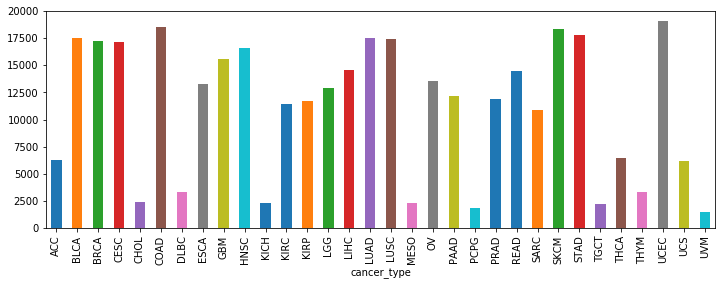

In [22]:
# Get the unique genes per cancer type
group_genes_by_cancer = mutations['train'].groupby(['cancer_type'])['gene'].nunique();
group_genes_by_cancer.plot.bar(figsize=(12,4))
print("Mean number of genes represented for each cancer type:", int(np.round(group_genes_by_cancer.mean())))
print("Min number of genes represented for each cancer type: ", int(np.round(group_genes_by_cancer.min())))
print("Max number of genes represented for each cancer type: ", int(np.round(group_genes_by_cancer.max())))

The above bar chart gives us an idea of how many genes (features for us) are _on_ for each of the cancer types. Cross referencing this chart with the previous one, we see that for some cancers such as DLBC and UCS we have a fair number of active features, even though the number of cases of such cancers are low. We should be able to person isolated (one-vs-rest) analysis for these cases. However, for other cancers, such as KICH (Kidney Chromophobe) and UVM (Uveal Melanoma) we have both a low occurance rate, and a low number of active features. This second category of cancers will need to be handled with care.

## Functions for feature engineering

In [23]:
# Create feature matrix each row is a patient tumor; each column is a gene
def create_patient_x_gene_matrix(mutations, feature_genes, description, save=True):
    cases = list()
    grouped = mutations.groupby('patient_barcode')
    i = int(0)

    cols = ['case_id', 'cancer_type']
    for gene in feature_genes:
        cols.append(gene)


    for name, group in grouped:
        case = list()
        case.append(name)
        for cc in group.cancer_type.head(1):
            case.append(cc)

        for gene_flag in feature_genes.isin(group.gene.unique()):
            switch = 0
            if gene_flag == True:
                switch = 1
            case.append(switch)
        cases.append(case)


    cases_df = pd.DataFrame(cases)
    cases_df.columns = cols
    print("  ", cases_df.shape)
    
    # Write out transformed data to csv
    if save:
        fileName = "./data/" + description + ".csv"
        print("  writing", fileName, "...")
        cases_df.to_csv(fileName)
        print("  done.")
    
    return cases_df


In [24]:
def show_genes_across_cancer_types(top_gene_cancer_matrix, top_n_gene_count, total_gene_count):
    plt.rcParams["figure.figsize"] = (10,4)
    sums_by_cancer_type = top_gene_cancer_matrix.sum(axis=1, skipna=True, numeric_only=True) 
    sorted = sums_by_cancer_type.sort_values(ascending=False).reindex()
    df = pd.DataFrame(sorted).reset_index()
    df.columns = ['gene', 'patient_count']
    df.reset_index()    
    title = 'Patient counts for genes (top ' + str(top_n_gene_count) + ')';
    ax = df.head(50).plot.bar(x='gene', y='patient_count', legend=None, title=title)

    cancer_type_present_count = top_gene_cancer_matrix.astype(bool).sum(axis=1, skipna=True, numeric_only=True)
    sorted = cancer_type_present_count.sort_values(ascending=False).reindex()
    df = pd.DataFrame(sorted).reset_index()
    df.columns = ['gene', 'present_in_cancer_type_count']
    df.reset_index()    

    axarr = df.hist(bins=32)

    for ax in axarr.flatten():
        ax.set_xlabel("Number of cancer types gene is present")
        ax.set_ylabel("Gene frequency")
    
    return df

In [25]:

def create_feature_matrix(mutations_train, mutations_test, top_n_gene_count, save, description, charts=True):
    print("Formatting gene matrix with top ", top_n_gene_count, "genes from each cancer type")
    
    # Now try to find the most common genes per cancer type and
    # merge these together to come up with a master list
    cancer_gene_count = mutations_train.groupby(['cancer_type', 'gene'])['patient_barcode'].nunique().reset_index(name='count')
    cancer_gene_count.columns = ['cancer_type', 'gene', 'patient_count']



    # Now create a large matrix, row is the gene, column for each cancer type
    df = pd.DataFrame(cancer_gene_count, columns=['cancer_type', 'gene', 'patient_count'])
    gene_cancer_matrix = pd.pivot_table(df, values='patient_count', index=['gene'],
                         columns=['cancer_type'], aggfunc=np.sum, fill_value=0)
    
    

    # Now find the top n genes for each cancer type
    top_genes = []
    idx = 0

    plt.rcParams["figure.figsize"] = (20,20)
    for cancer_type in gene_cancer_matrix.columns:
        sorted_genes = gene_cancer_matrix[cancer_type].sort_values(ascending=False)
        top_rows = sorted_genes[sorted_genes > 0].head(top_n_gene_count)
        for gene, patient_count in top_rows.items():
            top_genes.append(list([cancer_type, gene, patient_count]))


    # Turn this back into a matrix, row is gene, column for each cancer type
    top_df = pd.DataFrame(top_genes, columns=['cancer_type', 'gene', 'patient_count'])
    top_gene_cancer_matrix = pd.pivot_table(top_df, values='patient_count', index=['gene'],
                         columns=['cancer_type'], aggfunc=np.sum, fill_value=0)
    print("  number of genes:", top_gene_cancer_matrix.shape[0])
    if charts:
        show_genes_across_cancer_types(top_gene_cancer_matrix, 
                                   top_n_gene_count, 
                                   top_gene_cancer_matrix.shape[0] )
    feature_genes = top_gene_cancer_matrix.index
    print("  number of genes after filter:", len(feature_genes))
    create_patient_x_gene_matrix(mutations_train, feature_genes, description + ".train", save)
    create_patient_x_gene_matrix(mutations_test,  feature_genes, description + ".test", save)

In [26]:
def create_best_fit_feature_matrix(mutations_train, mutations_test, top_n_genes, n_features, 
                               save, description, charts=True):
    print("Formatting gene matrix with best fit for", n_features, "features")
    
    # Now try to find the most common genes per cancer type and
    # merge these together to come up with a master list
    cancer_gene_count = mutations_train.groupby(['cancer_type', 'gene'])['patient_barcode'].nunique().reset_index(name='count')
    cancer_gene_count.columns = ['cancer_type', 'gene', 'patient_count']



    # Now create a large matrix, row is the gene, column for each cancer type
    df = pd.DataFrame(cancer_gene_count, columns=['cancer_type', 'gene', 'patient_count'])
    gene_cancer_matrix = pd.pivot_table(df, values='patient_count', index=['gene'],
                         columns=['cancer_type'], aggfunc=np.sum, fill_value=0)
    
    

    # Now find the top n genes for each cancer type
    top_genes = []
    for cancer_type in gene_cancer_matrix.columns:
        sorted_genes = gene_cancer_matrix[cancer_type].sort_values(ascending=False)
        if (top_n_genes == None):
            top_rows = sorted_genes[sorted_genes > 0].head(top_n_genes)
        else:
            top_rows = sorted_genes
        for gene, patient_count in top_rows.items():
            top_genes.append(list([cancer_type, gene, patient_count]))


    # Turn this back into a matrix, row is patient, column for each gene
    top_df = pd.DataFrame(top_genes, columns=['cancer_type', 'gene', 'patient_count'])
    top_gene_cancer_matrix = pd.pivot_table(top_df, values='patient_count', index=['gene'],
                         columns=['cancer_type'], aggfunc=np.sum, fill_value=0)
    show_genes_across_cancer_types(top_gene_cancer_matrix, 
                               top_n_genes, 
                               n_features )

    #
    # Create feature matrix, each row is patient, columns are genes
    #
    feature_genes = top_gene_cancer_matrix.index
    print("  number of genes before best fit:     ", len(feature_genes))
    feature_matrix_train = create_patient_x_gene_matrix(mutations_train, feature_genes, '', False)
    feature_matrix_test  = create_patient_x_gene_matrix(mutations_test, feature_genes, '', False)
    
    #
    #  Try BestFit (chi squared test) to find most
    #  important genes
    #
    best_genes  = get_best_fit_features(feature_matrix_train, n_features)
    cancer_type = feature_matrix_train['cancer_type']
    case_id     = feature_matrix_train['case_id']
    data_train  = feature_matrix_train.loc[:, feature_matrix_train.columns.isin(best_genes)]
    
    print("  number of genes before after best fit:", data_train.shape[1])
    final_feature_matrix_train = pd.concat([case_id, cancer_type, data_train], axis=1)

    cancer_type = feature_matrix_test['cancer_type']
    case_id     = feature_matrix_test['case_id']
    data_test   = feature_matrix_test.loc[:, feature_matrix_test.columns.isin(best_genes)]
    final_feature_matrix_test = pd.concat([case_id, cancer_type, data_test], axis=1)
    
    if save:
        fileName = "./data/" + description  + ".train.csv"
        print("  writing", fileName, "...")
        print(" ", final_feature_matrix_train.shape)
        final_feature_matrix_train.to_csv(fileName)
        print("  done.")        
        
        fileName = "./data/" + description  + ".test.csv"
        print("  writing", fileName, "...")
        print(" ", final_feature_matrix_test.shape)
        final_feature_matrix_test.to_csv(fileName)
        print("  done.")        

In [27]:
def get_best_fit_features(feature_matrix, n_features):
    #apply SelectKBest class to extract top n best features
    bestfeatures = SelectKBest(score_func=chi2, k=n_features)
    
    data = feature_matrix.loc[:, (feature_matrix.columns != 'cancer_type') & (feature_matrix.columns != 'case_id')]
    labels_string = feature_matrix['cancer_type']
    
    le = preprocessing.LabelEncoder()
    labels = le.fit_transform(labels_string)
    
    fit = bestfeatures.fit(data,labels)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(data.columns)
    
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['gene','score']  
    display(featureScores.nlargest(10,'score'))  
    return list(featureScores.nlargest(n_features,'score')['gene'])

In [28]:
def create_all_feature_matrix(mutations_train, mutations_test, save, description):
    print("Formatting gene matrix with for all features")
    #
    # Create feature matrix, each row is patient, columns are genes
    #
    feature_genes = pd.Series(mutations_train.gene.unique())
    feature_matrix_train = create_patient_x_gene_matrix(mutations_train, feature_genes, description + ".train", save)
    feature_matrix_test  = create_patient_x_gene_matrix(mutations_test,  feature_genes, description + ".test", save)
    return feature_matrix_train, feature_matrix_test

In [29]:
def create_l1_feature_matrix(train_features, test_features, label_encoder, description, save):
    
    train_first_cols    = train_features[train_features.columns[:2]]
    train_data          = train_features[train_features.columns[3:]]
    train_labels        = label_encoder.fit_transform(train_features.cancer_type)

    test_first_cols    = test_features[test_features.columns[:2]]
    test_data          = test_features[test_features.columns[3:]]
    test_labels        = label_encoder.fit_transform(test_features.cancer_type)

    params = {'C':  [100, 10, 1, .5]}
    
    for c_param in reversed(params['C']):
        # Keep this random seed here to make comparison easier.
        np.random.seed(0)

        #
        # Perform Logistic Regression on different C values
        # using L1 regularization
        #
        l1 = LogisticRegression(penalty='l1', tol=.01, 
                            solver="liblinear", multi_class="ovr",
                            max_iter=500, C=c_param)
        # Fit model
        l1.fit(train_data, train_labels) 


        # Get the features with non-zero coefficients.  We will use
        # this list to reduce the features 
        non_zero_sums = np.where(np.sum(l1.coef_, axis=0) != 0)
        names = np.array(list(train_data.columns))
        non_zero_genes = names[non_zero_sums] 


        #
        # Reduce feature size, only keeping features with non-zero weights 
        # found using l1 regularization
        #
        trimmed_train_data = train_data[non_zero_genes]
        trimmed_test_data  = test_data[non_zero_genes]
        
        final_features_train = pd.concat([train_first_cols, trimmed_train_data], axis=1)
        final_features_test =  pd.concat([test_first_cols, trimmed_test_data], axis=1)
        
        if save:
            fileName = "./data/" + description + "_c" + str(c_param) + ".train.csv"
            print("  writing", fileName, "...")
            print(" ", final_features_train.shape)
            final_features_train.to_csv(fileName)
            print("  done.")        

            fileName = "./data/" + description + "_c" + str(c_param) + ".test.csv"
            print("  writing", fileName, "...")
            print(" ", final_features_test.shape)
            final_features_test.to_csv(fileName)
            print("  done.")        
        


In [30]:
def create_rfe_feature_matrix(train_features, test_features, label_encoder, description, save):
    train_first_cols    = train_features[train_features.columns[:2]]
    train_data          = train_features[train_features.columns[3:]]
    train_labels        = label_encoder.fit_transform(train_features.cancer_type)

    test_first_cols    = test_features[test_features.columns[:2]]
    test_data          = test_features[test_features.columns[3:]]
    test_labels        = label_encoder.fit_transform(test_features.cancer_type)

    lr = LogisticRegression(penalty='l2', tol=.01, max_iter=150, 
                            C=0.25, 
                            solver="liblinear", multi_class="ovr")
    rfe = RFE(estimator=lr, n_features_to_select=800, step=1)
    rfe.fit(train_data, train_labels)
    ranking = rfe.ranking_
    print(ranking)

## Create different feature sets

### Top n genes most frequent in each cancer type

Formatting gene matrix with top  1000 genes from each cancer type
  number of genes: 8865
  number of genes after filter: 8865


KeyboardInterrupt: 

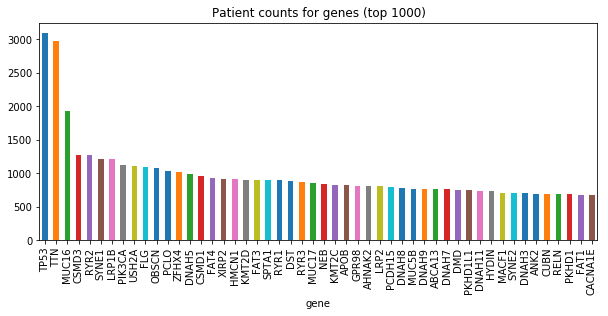

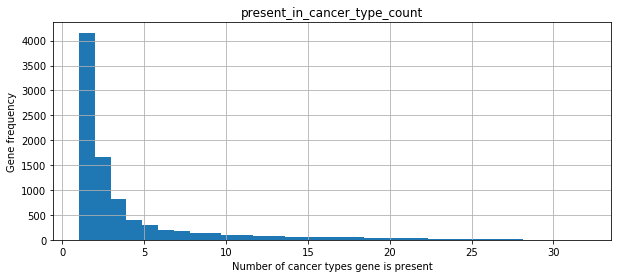

In [31]:
# Create a feature matrix, getting the top n genes that are most frequent
# per label (cancer type).  Merge these genes and create a feature matrix,
# one row per patient tumor, column for each merged gene
create_feature_matrix(mutations['train'], mutations['test'], 1000, True, 'features_topgenes_small')

### Use KBestFit to find best features (genes)

In [ ]:
# Create a feature matrix, getting the top 1000 genes that are most frequent
# per label (cancer type).  Merge these genes.
# Then use sklearn BestFit to find top 5000 genes.
# Feature matrix will have one row per patient tumor, 
# column for each 'bestfit' gene
create_best_fit_feature_matrix(mutations['train'], mutations['test'], 1000, 5000, True, 
                          'features_bestfit_with_topgenes')

In [ ]:
# Create a feature matrix, using sklearn BestFit to find top 
# 5000 genes. Feature matrix will have one row per patient tumor, 
# column for each 'bestfit' gene
create_best_fit_feature_matrix(mutations['train'], mutations['test'], None, 5000, True,  
                           'features_bestfit_med')

In [ ]:
# Create a feature matrix, using sklearn BestFit to find top 
# 8000 genes. Feature matrix will have one row per patient tumor, 
# column for each 'bestfit' gene
create_best_fit_feature_matrix(mutations['train'], mutations['test'],None, 8000, True,  
                           'features_bestfit_large')

### Use all genes

In [ ]:
# Create a feature matrix,  Feature matrix will have one row per patient tumor, 
# column for every gene encountered in training data set.
feature_matrix_train, feature_matrix_test = create_all_feature_matrix(mutations['train'], 
                                                                   mutations['test'], True, 'features_all')

### Use Recursive Feature Elimination

In [ ]:
#
# Trim the features using Recursive Feature Elimination
#
#label_encoder            = preprocessing.LabelEncoder()
#create_rfe_feature_matrix(feature_matrix_train, feature_matrix_test, label_encoder, 
#                          'rfe_logit', True)

### Use Logistic Regression with L1 regularization a different C values

In [ ]:
#
# Trim the features using Logistic Regression, L1 regularization
#
label_encoder            = preprocessing.LabelEncoder()
create_l1_feature_matrix(feature_matrix_train, feature_matrix_test, label_encoder,
           'features_l1reg', True)

### Use PCA for dimensionality reduction

In [ ]:
pca = PCA()
all_features_train = feature_matrix_train.drop(columns=['case_id', 'cancer_type'])
pca.fit(all_features_train)
ev = np.cumsum(pca.explained_variance_ratio_)
evcount = len(ev[ev<99.0])
print("Number of features that explain 99% of the variance: ", evcount)
pca = PCA(n_components=evcount)
pca.fit(all_features_train)
train_PCA = pca.transform(all_features_train)
all_features_test = feature_matrix_test.drop(columns=['case_id', 'cancer_type'])
test_PCA = pca.transform(all_features_test)


In [ ]:
train_PCA_df = pd.DataFrame(train_PCA)
train_PCA_df['case_id'] = feature_matrix_train['case_id']
train_PCA_df['cancer_type'] = feature_matrix_train['cancer_type']

test_PCA_df = pd.DataFrame(test_PCA)
test_PCA_df['case_id'] = feature_matrix_test['case_id']
test_PCA_df['cancer_type'] = feature_matrix_test['cancer_type']

#reorder columns and write out
for df, f_name in zip( (train_PCA_df, test_PCA_df), 
                      ('./data/features_after_pca.train.csv', './data/features_after_pca.test.csv') ):
  cols = df.columns.tolist()
  cols = cols[-2:] + cols[:-2]
  df = df[cols]
  df.to_csv(f_name)


# Run the Classifiers

## Load the data

In [ ]:
# TCGA dictionary information
tcga_dict = open("./data/tcga_dictionaries.txt","r")
dict_name_index = 0 #Set dictionary index counter to 0
for line in tcga_dict:
    if line.startswith("#"): #If line starts with #, the next line will be a known dictionary
        dict_name_index += 1
    elif dict_name_index == 5:
        code_to_disease = eval(line)
        

In [ ]:
def getDataAndLabels(name, features, label_encoder):
    labels_string = features.cancer_type
   
    labels        = label_encoder.fit_transform(labels_string)

    # Get rid of the cancer type and patient_barcode columns 
    if (name == 'after_pca'):
        data = features[features.columns[1:-2]]
    else:
        data = features[features.columns[3:]]

    return {'name': name, 'feature_size': data.shape[1],
            'data': data, 'labels': labels , 'label_encoder': label_encoder }

In [ ]:
print('Loading training data ...')
# label encoder
label_encoder   = preprocessing.LabelEncoder()

# get all file names that start with features_
train_files = glob.glob("./data/features_*.train.csv")
all_train_data = {}

# load all of the files
for filename in train_files:
    
    name = filename[16:-10]
    #if (name != 'after_pca'):
    print(" ", name)
    train_features = pd.read_csv(filename)
    all_train_data[name] = getDataAndLabels(name, train_features, label_encoder)

print("done.")

In [ ]:
print('Loading test data ...')

test_files = glob.glob("./data/features_*.test.csv")
all_test_data = {}
for filename in test_files:
    
    name = filename[16:-9]
    #if (name != 'after_pca'):
    print(" ", name)
    test_features = pd.read_csv(filename)
    all_test_data[name] = getDataAndLabels(name, test_features, label_encoder)

print("done.")

## Functions for running different classifiers

In [ ]:
def getBestParamsLogit(train_data, train_labels):
    #
    # Logistic Regression
    #
    lr = LogisticRegression(penalty='l2', multi_class = 'ovr', solver='liblinear', max_iter=150)
    params = {'C': [0.1, 0.25,  0.5,]}
    logit = GridSearchCV(lr, params, cv=5,
                         scoring='accuracy', return_train_score=True)

    # Fit  training data
    logit.fit(train_data, train_labels)  
    # Show the best C parameter to use and the expected accuracy
    print(' Best param:', logit.best_params_)
    print(' Accuracy:  ', np.round(logit.best_score_, 4) )
    
    return logit.best_params_

In [ ]:
def getBestParamsSVM(train_data, train_labels):
    #
    # SVM
    #
    classifier = LinearSVC(penalty='l2')

    params = {'C': [0.01, 0.1, 0.5]}
    svm = GridSearchCV(classifier, params, cv=4, 
                       scoring='accuracy', return_train_score=True)

    # Fit  training data
    svm.fit(train_data, train_labels)  
    # Show the best C parameter to use and the expected accuracy
    print(' Best param:', svm.best_params_)
    print(' Accuracy:  ', np.round(svm.best_score_, 4) )
    
    return svm.best_params_

In [ ]:
#
# Logistic regression
#
def run_logistic_regression(train_data, train_labels, test_data, test_labels, name, hyper_params, scores):
  if name in hyper_params and 'lr' in hyper_params[name]:
      best_params_logit = hyper_params[name]['lr']
  else:
      print("Running grid search on Logistic Regression...")
      best_params_logit = getBestParamsLogit(train_data, train_labels)

  # Run logistic regression with L2 regularization on reduced
  # feature set
  lr = LogisticRegression(penalty='l2', tol=.01, max_iter=150, 
                          C=best_params_logit['C'], 
                          solver="liblinear", multi_class="ovr")
  lr.fit(train_data, train_labels) 
  predict = lr.predict(test_data)

  # Get precision, recall, f1 scores
  logit_prf_scores      = precision_recall_fscore_support(test_labels, predict, average='weighted')
  logit_scores_by_label = precision_recall_fscore_support(test_labels, predict, average=None)

  # Get confusion matrix
  logit_confusion       = confusion_matrix(test_labels, predict)

  print("\nLogistic Regression", name)
  print("  precision:", np.round(logit_prf_scores[0], 4))  
  print("  recall:   ", np.round(logit_prf_scores[1], 4))  
  print("  f1:       ", np.round(logit_prf_scores[2], 4))   

  return [
          logit_prf_scores[0],
          logit_prf_scores[1],
          logit_prf_scores[2],
          logit_scores_by_label,
          logit_confusion]

In [ ]:
#
# Linear SVM
#
def run_linear_svm(train_data, train_labels, test_data, test_labels, name, hyper_params, scores):
  print("\nLinear SVM", name)

  if name in hyper_params and 'svm' in hyper_params[name]:
    best_params_svm = hyper_params[name]['svm']
  else:
      print("Running grid search on Linear SVM...")
      best_params_svm = getBestParamsSVM(train_data, train_labels)

  svm = LinearSVC(penalty='l2', C=best_params_svm['C'])

  svm.fit(train_data, train_labels,) 
  predict = svm.predict(test_data)

  # Get precision, recall, f1 scores
  svm_prf_scores      = precision_recall_fscore_support(test_labels, predict, average='weighted')
  svm_scores_by_label = precision_recall_fscore_support(test_labels, predict, average=None)

  # Get confusion matrix
  svm_confusion       = confusion_matrix(test_labels, predict)

  print("  precision:", np.round(svm_prf_scores[0], 4))  
  print("  recall:   ", np.round(svm_prf_scores[1], 4))  
  print("  f1:       ", np.round(svm_prf_scores[2], 4))      
  
  return [
          svm_prf_scores[0],
          svm_prf_scores[1],
          svm_prf_scores[2],
          svm_scores_by_label,
          svm_confusion]

In [ ]:
#
# Decision tree
#
def run_decision_tree(train_data, train_labels, test_data, test_labels, name, hyper_params, scores):

    print("\nDecision Tree", name)

    dt = DecisionTreeClassifier()
    
    dt.fit(train_data, train_labels,) 
    predict = dt.predict(test_data)

    # Get precision, recall, f1 scores
    dt_prf_scores      = precision_recall_fscore_support(test_labels, predict, average='weighted')
    dt_scores_by_label = precision_recall_fscore_support(test_labels, predict, average=None)

    # Get confusion matrix
    dt_confusion       = confusion_matrix(test_labels, predict)

    
    print("  precision:", np.round(dt_prf_scores[0], 4))  
    print("  recall:   ", np.round(dt_prf_scores[1], 4))  
    print("  f1:       ", np.round(dt_prf_scores[2], 4))
    
    return [
          dt_prf_scores[0],
          dt_prf_scores[1],
          dt_prf_scores[2],
          dt_scores_by_label,
          dt_confusion]

In [ ]:
#
# Random forest
#
def run_random_forest(train_data, train_labels, test_data, test_labels, name, hyper_params, scores):
    print("\nRandom Forest", name)

    rf = RandomForestClassifier(n_estimators=500)
    
    rf.fit(train_data, train_labels,) 
    predict = rf.predict(test_data)

    # Get precision, recall, f1 scores
    rf_prf_scores      = precision_recall_fscore_support(test_labels, predict, average='weighted')
    rf_scores_by_label = precision_recall_fscore_support(test_labels, predict, average=None)

    # Get confusion matrix
    rf_confusion       = confusion_matrix(test_labels, predict)
    
    print("  precision:", np.round(rf_prf_scores[0], 4))  
    print("  recall:   ", np.round(rf_prf_scores[1], 4))  
    print("  f1:       ", np.round(rf_prf_scores[2], 4)) 
    
    return [
          rf_prf_scores[0],
          rf_prf_scores[1],
          rf_prf_scores[2],
          rf_scores_by_label,
          rf_confusion]

In [ ]:
#
# Neural Net
#
def run_neural_net(train_data, train_labels, test_data, test_labels, name, hyper_params, scores):
    print("\nNeural Net", name)

    tr_lab = to_categorical(train_labels)
    test_lab = to_categorical(test_labels)
    model = K.Sequential()
    model.add(Dense(2000, input_dim=train_data.shape[1], activation='relu', 
                    kernel_regularizer=regularizers.l1_l2(l2=0.01,l1=0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(400, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='sigmoid'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ["accuracy"])
    #model.fit(train_data, tr_lab, epochs=1000, batch_size=100)
    model.fit(train_data, tr_lab, epochs=100, batch_size=100)
    evaluate = model.evaluate(x = test_data, y = test_lab)
    predict = model.predict(test_data)    
    
    # Get precision, recall, f1 scores
    nn_prf_scores      = precision_recall_fscore_support(test_labels,np.argmax(predict,1), average='weighted')
    nn_scores_by_label = precision_recall_fscore_support(test_labels,np.argmax(predict,1), average=None)

    # Get confusion matrix
    #nn_confusion       = confusion_matrix(test_labels, predict)
    
    print("  precision:", np.round(nn_prf_scores[0], 4))  
    print("  recall:   ", np.round(nn_prf_scores[1], 4))  
    print("  f1:       ", np.round(nn_prf_scores[2], 4))  
    
    return [
          nn_prf_scores[0],
          nn_prf_scores[1],
          nn_prf_scores[2],
          nn_scores_by_label,
          []]

In [ ]:
#
# XGBoost
#
def run_xg_boost(train_data, train_labels, test_data, test_labels, name, hyper_params, scores):
    print("\nXG Boost", name)

    xgb_params = {
    'max_depth': 2, 
    'eta': 0.3,  
    'silent': False,  
    'verbose': True,
    'objective': 'multi:softprob',  
    'num_class': 32,
    'num_boost_round' : 2}  

    xgb_cfr = xgb.XGBClassifier(**xgb_params)
    xgb_cfr.fit(train_data, train_labels)
    
    predict = xgb_cfr.predict(test_ata)
    
    # Get precision, recall, f1 scores
    xgb_prf_scores      = precision_recall_fscore_support(test_labels, predict, average='weighted')
    xgb_scores_by_label = precision_recall_fscore_support(test_labels, predict, average=None)

    # Get confusion matrix
    xgb_confusion       = confusion_matrix(test_labels, predict)
    
    print("  precision:", np.round(xgb_prf_scores[0], 4))  
    print("  recall:   ", np.round(xgb_prf_scores[1], 4))  
    print("  f1:       ", np.round(xgb_prf_scores[2], 4))  
    
    return  [
            xgb_prf_scores[0],
            xgb_prf_scores[1],
            xgb_prf_scores[2],
            xgb_scores_by_label,
            xgb_confusion]

## Run the different classifiers 

In [ ]:
def runClassifiers(train_data, train_labels, test_data, test_labels, name, hyper_params, scores):

    lr_scores = run_logistic_regression(train_data, train_labels, test_data, test_labels, name, hyper_params, scores)

    svm_scores = run_linear_svm(train_data, train_labels, test_data, test_labels, name, hyper_params, scores)
    
    dt_scores = run_decision_tree(train_data, train_labels, test_data, test_labels, name, hyper_params, scores)

    rf_scores = run_random_forest(train_data, train_labels, test_data, test_labels, name, hyper_params, scores)
       
    nn_scores = run_neural_net(train_data, train_labels, test_data, test_labels, name, hyper_params, scores)

    scores[name] = {}
    scores[name]['lr'] = lr_scores
    scores[name]['svm'] = svm_scores
    scores[name]['dt'] = dt_scores
    scores[name]['rf'] = rf_scores
    scores[name]['nn'] = nn_scores
    

In [ ]:
hyper_params = {
    'l1reg_c0.5':           {'lr': {'C': 0.25}, 'svm': {'C': 0.01}},
    'l1reg_c1':             {'lr': {'C': 0.25}, 'svm': {'C': 0.01}},
    'l1reg_c10':            {'lr': {'C': 0.1},  'svm': {'C': 0.01}},
    'l1reg_c100':           {'lr': {'C': 0.25}, 'svm': {'C': 0.01}},
    'topgenes_small':       {'lr': {'C': 0.25}, 'svm': {'C': 0.01}},
    'bestfit_med':          {'lr': {'C': 0.1 }, 'svm': {'C': 0.01}},
    'bestfit_large':        {'lr': {'C': 0.1 }, 'svm': {'C': 0.01}},
    'all':                  {'lr': {'C': 0.25}, 'svm': {'C': 0.01}},
    'bestfit_with_topgenes':{'lr': {'C': 0.1 }, 'svm': {'C': 0.01}},
    'after_pca':            {'lr': {'C': 0.5 }, 'svm': {'C': 0.01}}
}


scores = {}


for name in all_train_data.keys():
    print("************************")
    print(name)
    print("************************")

    train      = all_train_data[name]
    test       = all_test_data[name]

    runClassifiers(train['data'], train['labels'], test['data'], test['labels'], name, hyper_params, scores)

## Visualize Performance across different feature sets, different classifiers

In [ ]:
colors = {'lr': 'olivedrab', 'svm': 'slateblue', 
          'dt': 'mediumseagreen', 'rf': 'goldenrod',
          'xgb': 'coral', 'nn': 'crimson'}

df_scores = pd.DataFrame(scores)
rows = []
for name in all_train_data.keys():    
    for classifier in ['lr', 'svm', 'dt', 'rf', 'nn']:
        rows.append([name,
                     all_train_data[name]['feature_size'],
                    classifier,
                    df_scores.loc[classifier][name][0],
                    df_scores.loc[classifier][name][1],
                    df_scores.loc[classifier][name][2]])

df_report = pd.DataFrame(rows, columns=['name', 'feature_size', 'classifier', 'precision', 'recall', 'f1'])


In [ ]:
def plot_classifier_metrics(df_report, label_encoder):
    
    plt.rcParams["figure.figsize"] = (20,20)

    labels = []
    for key, group in df_report.groupby(['feature_size', 'name']):
        labels.append(str(key[0]) + '\n' + key[1])
        
    sorted_df_report = df_report.sort_values(by=['classifier', 'feature_size', 'name'], ascending=[1,1,1])


        
    for classifier, group in sorted_df_report.groupby(['classifier']):

        plt.plot(labels, group.precision.values, color=colors[classifier], 
                 linewidth=3, label=classifier + " precision", marker='o' )
        plt.plot(labels, group.recall.values, color=colors[classifier], linestyle="dashed",
                 linewidth=3, label=classifier + " recall", marker='o' )
    

    plt.yticks(np.arange(0, .65, .01))
    plt.ylabel('Precision, Recall', fontsize=20)
    plt.xlabel('Precision and Recall across different Features and Classifiers', fontsize=20, labelpad=20)
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def show_precision_recall_by_label(precision_by_label, recall_by_label, name, classifier, label_encoder):

    labels = []
    for i in range(len(precision_by_label)):
        label = label_encoder.inverse_transform([i])[0]
        labels.append(label)
    
    y_pos = np.arange(len(labels))    

    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)

    ax1.invert_xaxis()
    ax1.yaxis.tick_right()
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(labels)
    
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(labels)
        
    ax1.barh(y_pos, precision_by_label, color=colors[classifier] , label="precision")
    ax2.barh(y_pos, recall_by_label,    color=colors[classifier],  label='recall')

    ax1.set_title('Precision( ' + classifier + ')')
    ax2.set_title('Recall (' + classifier + ')')
    
    plt.grid()
    plt.show()

In [ ]:
def coords_of_max(theArray, n):
    # Flatten the 2D array
    flat = theArray.flatten()
    # Partition so that the we know the sort order for
    # the cells with the highest values.  We just
    # care about the top n highest values.  So for example,
    # if n = 3, get return 3 indices.  
    indices = np.argpartition(flat, -n)[-n:]
    # Reverse so that we show index of highest value first
    # (descending)
    indices = indices[np.argsort(-flat[indices])]
    # Now return the coordinates for these indices
    # for a 2D array.  This will return 2 arrays,
    # the first for the row index, the second for the
    # column index.  The row index represents the
    # actual digit, the column index represents
    # the confused digit
    return np.unravel_index(indices, theArray.shape)

In [ ]:
def show_confusion_matrix(conf_mx, label_encoder):
    # Determine the error rates for each misclassification pair
    row_sums = conf_mx.sum(axis=1, keepdims=True)
    norm_conf_mx = conf_mx / row_sums
    # Set the error rates for correctly classified pairs (the diagonal) to zero
    np.fill_diagonal(norm_conf_mx, 0)
    
    max_coords = coords_of_max(norm_conf_mx, 20)
    confusion_rows = []
    for i in range(len(max_coords[0])):

        # This is the actual label
        actual_label_idx  = max_coords[0][i]
        actual_label      = label_encoder.inverse_transform([actual_label_idx])[0]

        # This is the predicted label
        predicted_label_idx = max_coords[1][i]
        predicted_label = label_encoder.inverse_transform([predicted_label_idx])[0]
        
        # This is the error rate
        error_rate  = norm_conf_mx[max_coords[0][i], max_coords[1][i]]
        error_count = conf_mx[max_coords[0][i], max_coords[1][i]]

        row = list([ actual_label,                     
                     predicted_label,
                     code_to_disease[actual_label][0], 
                     code_to_disease[predicted_label][0], 
                     error_rate, 
                     error_count ])
        confusion_rows.append(row)
    
    df = pd.DataFrame(confusion_rows, columns=['actual', 'predicted',  'actual_name', 'predicted_name', 'error_rate', 'error_count'])
    display(df)

In [ ]:
# Plot precision and accuracy across different classifiers
plot_classifier_metrics(df_report, label_encoder)

In [ ]:
display(df_report)

In [ ]:
# best precision
sorted_df = df_report.sort_values(by='precision', ascending=0)
best_precision = sorted_df.head(1)

# best recall
sorted_df = df_report.sort_values(by='recall', ascending=0)
best_recall = sorted_df.head(1)

# best f1
sorted_df = df_report.sort_values(by='f1', ascending=0)
best_f1 = sorted_df.head(1)

# Show the feature set and classifier with the best 
# precision, recall, and f1 scores
print("\n\nBest precision")
display(best_precision)
print("\n\nBest recall")
display(best_recall)
print("\n\nBest f1")
display(best_f1)

# get the scores by label and confusion matrix
# for the best prediction
best_prediction = best_precision
best_name       = best_prediction.name.values[0]
best_classifier = best_prediction.classifier.values[0]
precision_by_label = scores[best_name][best_classifier][3][0]
recall_by_label = scores[best_name][best_classifier][3][1]
best_confusion_matrix = scores[best_name][best_classifier][4]

# show a side-by-side barchart of precision and recall for each label
print("\n\nPrecision and Recall by Label for classifier ")
print("Classifier:", best_classifier, "Feature set:", best_name)
show_precision_recall_by_label(precision_by_label, recall_by_label,
                               best_name, best_classifier, label_encoder)
                                                      
                                                      
# show the confusion matrix for the best performing classifier/feature set
show_confusion_matrix(best_confusion_matrix, label_encoder)                                                      


In [ ]:
# Write out scores as csv files
print("\nWriting metrics ...")
df_report.to_csv("./data/metrics.csv")
print("done.")

display(df_report)


In [ ]:
df_confusion_matrix = pd.DataFrame(best_confusion_matrix)
df_precision_by_label = pd.DataFrame(precision_by_label)
df_recall_by_label = pd.DataFrame(recall_by_label)

print("\nWriting metrics ...")
df_confusion_matrix.to_csv("./data/metrics_confusion_matrix.csv")
print("done.")

print("\nWriting metrics ...")
df_precision_by_label.to_csv("./data/metrics_precision_by_label.csv")
print("done.")

print("\nWriting metrics ...")
df_recall_by_label.to_csv("./data/metrics_recall_by_label.csv")
print("done.")

